In [179]:
import torch
import numpy as np  
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from utils import *
from IPython.display import display, clear_output

In [180]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Number of training samples: {len(train_dataset)}")

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 60000
Number of test samples: 10000


In [252]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.sequential(x)

    def backprop(self, grad_output):
        # Dummy backward pass
        grad_input = torch.autograd.grad(outputs=self.fc.weight, inputs=self.fc.weight, grad_outputs=grad_output)
        return grad_input

In [294]:
n_clients = 2

train_loaders = split_dataset(train_dataset, n_clients)

clients = [Client(model=Model(), dataloader=train_loaders[k], id=k+1) for k in range(n_clients)]
server = Server(model=Model())
net = FedNetwork(clients, server)

In [295]:
for i in tqdm(range(1_000)):

    # Initialize clients with server parameters
    net.initialize_clients()

    # Train clients and get gradients
    params, grads = net.train_clients()

    # Update server with gradients from clients
    net.update_client(grads, lr=0.1)

    # Evaluate server every 100 iterations
    if (i+1) % 100 == 0:
        print(f'Iteration {i+1} | Server eval: {evaluate(net.server.model, test_loader)}')

 11%|█         | 110/1000 [00:02<00:37, 23.66it/s]

Iteration 100 | Server eval: 0.688


 21%|██        | 208/1000 [00:05<00:31, 24.90it/s]

Iteration 200 | Server eval: 0.8901


 31%|███       | 306/1000 [00:07<00:27, 25.12it/s]

Iteration 300 | Server eval: 0.8995


 41%|████      | 410/1000 [00:09<00:22, 25.68it/s]

Iteration 400 | Server eval: 0.9032


 51%|█████     | 507/1000 [00:12<00:23, 20.62it/s]

Iteration 500 | Server eval: 0.9099


 61%|██████    | 609/1000 [00:15<00:19, 20.41it/s]

Iteration 600 | Server eval: 0.9265


 71%|███████   | 706/1000 [00:17<00:14, 20.77it/s]

Iteration 700 | Server eval: 0.9393


 81%|████████  | 808/1000 [00:20<00:09, 19.88it/s]

Iteration 800 | Server eval: 0.9402


 91%|█████████ | 908/1000 [00:23<00:04, 20.59it/s]

Iteration 900 | Server eval: 0.9402


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]

Iteration 1000 | Server eval: 0.951


In [296]:
class AttackerGAN(Client):
    def __init__(self, discriminator, generator, dataloader, id, target_class, n_gen_train, noise_dim=100, lr=1e-5):
        super(AttackerGAN, self).__init__(discriminator, dataloader, id)
        self.generator = generator(noise_dim=noise_dim)
        self.optimizerG = torch.optim.Adam(self.generator.parameters(), lr=lr)
        self.noise_dim = noise_dim
        self.target_vector = torch.zeros(64,10)
        self.target_vector[:,target_class] = 1
        self.mislabel_vector = torch.ones(64,10)
        self.n_gen_train = n_gen_train

    def train(self):

        # Training the Generator
        self.model.eval()
        self.generator.train()

        for _ in range(self.n_gen_train):
            noise = torch.randn(64, self.noise_dim)
            generated_data = self.generator(noise)
            pred_class = self.model(generated_data)
            loss = self.loss_func(pred_class, self.target_vector)
            self.optimizerG.zero_grad()
            loss.backward()
            self.optimizerG.step()

        # Training the Discriminator
        self.model.train()
        self.generator.eval()

        noise = torch.randn(64, self.noise_dim)
        generated_data = self.generator(noise)
        pred_class = self.model(generated_data)
        loss = self.loss_func(pred_class, self.mislabel_vector)
        self.optimizer.zero_grad()
        loss.backward()

    def generate(self):
        return self.generator.generate()
        

In [297]:
class Generator(torch.nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.noise_dim, 16*28*28),

            torch.nn.Unflatten(1, (16, 28, 28)),

            torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(8),

            torch.nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(4),

            torch.nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.Tanh()
        )


    def forward(self, x):
        return self.model(x)
    
    def generate(self):
        noise = torch.rand(1, self.noise_dim)
        image_gen = self.forward(noise)
        return image_gen.view(1, 28, 28)

In [298]:
attacker = AttackerGAN(discriminator=Model(), generator=Generator, dataloader=None, id=-1, target_class=5, n_gen_train=10, noise_dim=100, lr=2e-5)

if -1 in net.client_ids:
    net.drop_client(-1)
    
net.add_client(attacker)

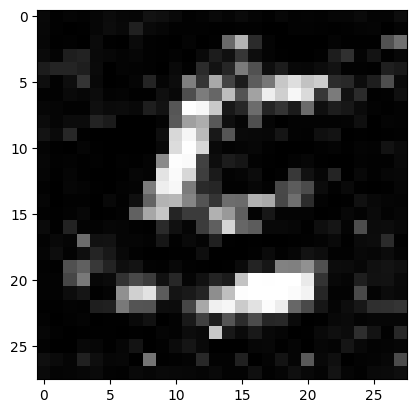

100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]


In [299]:
for i in tqdm(range(1000)):

    # Initialize clients with server parameters
    net.initialize_clients()

    # Train clients and get gradients
    params, grads = net.train_clients()

    # Update server with gradients from clients
    net.update_client(grads, lr=1e-2)

    # Evaluate server every 100 iterations
    if (i+1) % 5 == 0:
        clear_output(wait=True)
        image = net.clients[-1].generator(torch.rand(1, 100))
        plt.imshow(image.detach().view(28, 28).numpy(), cmap='gray')
        plt.show()

# GAN Attack with target = 0

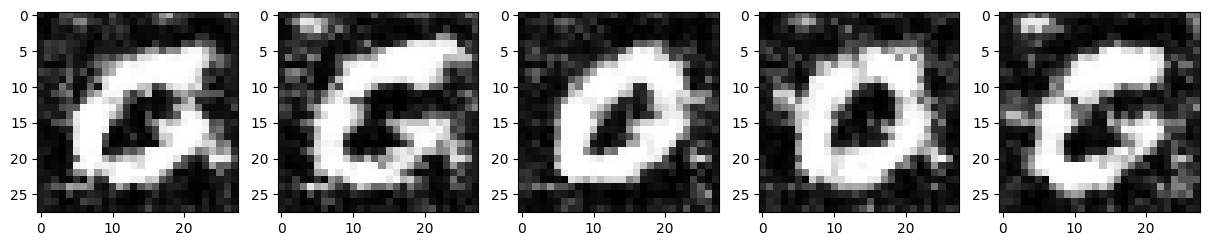

In [233]:
n_test = 5

fig, ax = plt.subplots(1, n_test, figsize=(15, 15))
for i in range(n_test):
    image = net.clients[-1].generate()
    ax[i].imshow(image.detach().view(28, 28).numpy(), cmap='gray')
plt.show()

# GAN Attack with target = 3

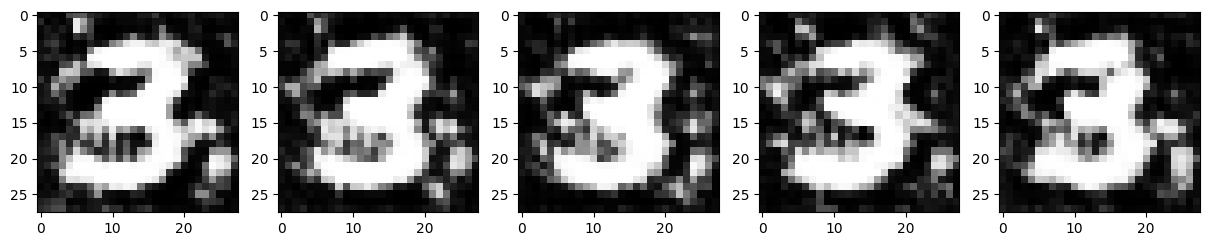

In [251]:
n_test = 5

fig, ax = plt.subplots(1, n_test, figsize=(15, 15))
for i in range(n_test):
    image = net.clients[-1].generate()
    ax[i].imshow(image.detach().view(28, 28).numpy(), cmap='gray')
plt.show()

In [ ]:
n_test = 5

fig, ax = plt.subplots(1, n_test, figsize=(15, 15))
for i in range(n_test):
    image = net.clients[-1].generate()
    ax[i].imshow(image.detach().view(28, 28).numpy(), cmap='gray')
plt.show()

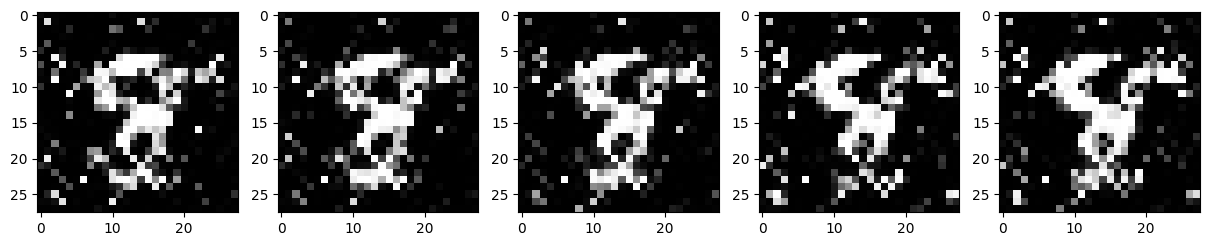

In [277]:
n_test = 5

fig, ax = plt.subplots(1, n_test, figsize=(15, 15))
for i in range(n_test):
    image = net.clients[-1].generate()
    ax[i].imshow(image.detach().view(28, 28).numpy(), cmap='gray')
plt.show()

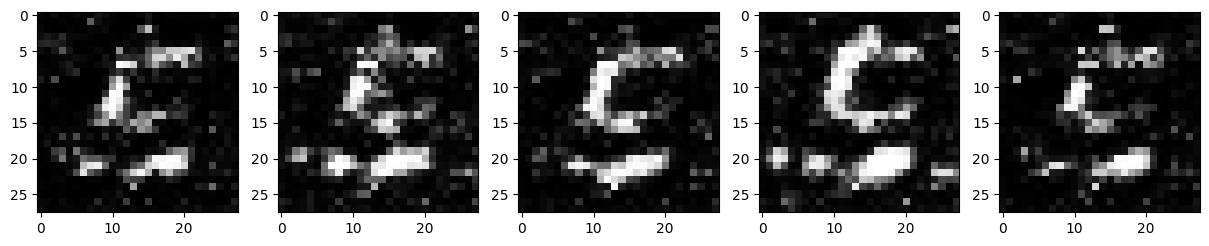

In [300]:
n_test = 5

fig, ax = plt.subplots(1, n_test, figsize=(15, 15))
for i in range(n_test):
    image = net.clients[-1].generate()
    ax[i].imshow(image.detach().view(28, 28).numpy(), cmap='gray')
plt.show()

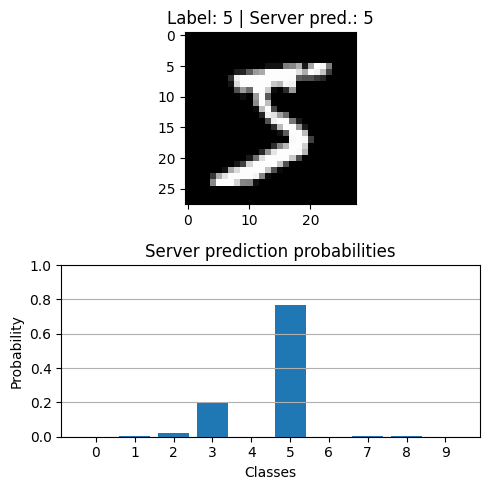

In [216]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5))

image = train_dataset[0][0].unsqueeze(0)  # Get a sample image
label = train_dataset[0][1]  # Get the corresponding
pred = net.server(image)  # Forward pass through the server model

ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title(f"Label: {label} | Server pred.: {pred.argmax(dim=1).item()}")

ax[1].bar(range(10), torch.nn.functional.softmax(pred.squeeze().detach(), dim=0).numpy())
ax[1].set_title("Server prediction probabilities")      
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Probability")
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(range(10))
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

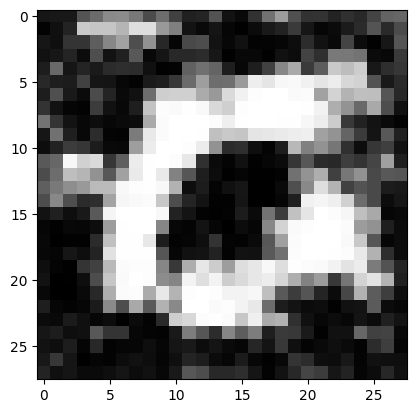

In [227]:
image = net.clients[-1].generate()
plt.imshow(image.detach().view(28, 28).numpy(), cmap='gray')

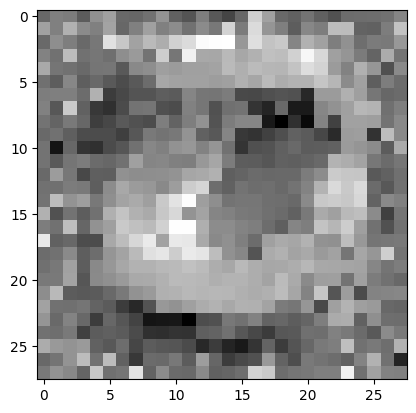

 75%|███████▍  | 14905/20000 [00:35<00:12, 417.07it/s, loss=1.19e-7]


Text(0.5, 1.0, 'Reconstructed digit: 6')

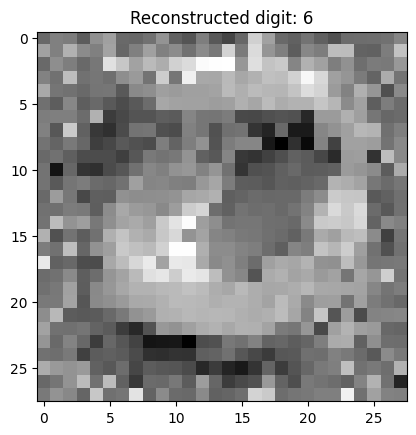

In [66]:
digit = 6
n_steps = 20_000

# prob_tensor = torch.full((1,28*28), 0.01)
# dummy = torch.bernoulli(prob_tensor)
# dummy.requires_grad = True

dummy = torch.ones(1, 28 * 28, requires_grad=True)

y = torch.zeros(1,10)
y[0,digit] = 1

optimizer = torch.optim.Adam([dummy], lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

with tqdm(total=n_steps) as pbar:
    for i in range(n_steps):
        output = net.server(dummy)

        loss = loss_func(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if loss.item() == 0:
            break

        if i%100==0:
            clear_output(wait=True)
            plt.imshow(dummy.detach().view(28, 28).numpy(), cmap='gray')
            plt.show()

        pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)

plt.imshow(dummy.detach().view(28, 28).numpy(), cmap='gray')
plt.title(f"Reconstructed digit: {digit}")

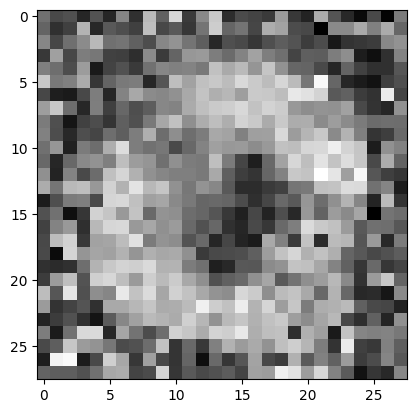

In [15]:
1
plt.imshow(dummy.detach().view(28, 28).numpy(), cmap='gray')

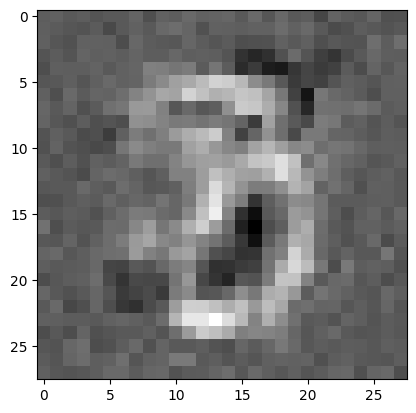

In [293]:
8
plt.imshow(dummy.detach().view(28, 28).numpy(), cmap='gray')

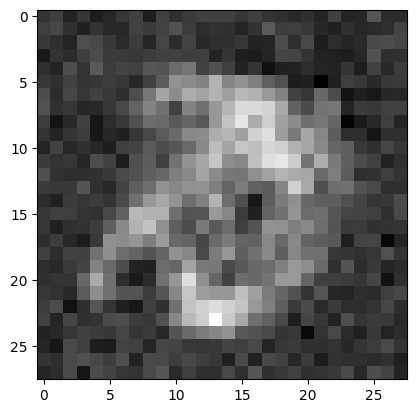

In [ ]:
0
plt.imshow(dummy.detach().view(28, 28).numpy(), cmap='gray')

  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\gjper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:829: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\engine.cpp:1296.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  3%|▎         | 9/300 [00:00<00:03, 87.69it/s]

Step 0, Grad MSE: 0.000073


 26%|██▌       | 77/300 [00:00<00:01, 206.58it/s]

Step 50, Grad MSE: 0.000006


 48%|████▊     | 145/300 [00:00<00:00, 212.56it/s]

Step 100, Grad MSE: 0.000004


 63%|██████▎   | 189/300 [00:00<00:00, 208.36it/s]

Step 150, Grad MSE: 0.000003


 77%|███████▋  | 231/300 [00:01<00:00, 202.47it/s]

Step 200, Grad MSE: 0.000003


 92%|█████████▏| 276/300 [00:01<00:00, 210.11it/s]

Step 250, Grad MSE: 0.000002


100%|██████████| 300/300 [00:01<00:00, 205.75it/s]


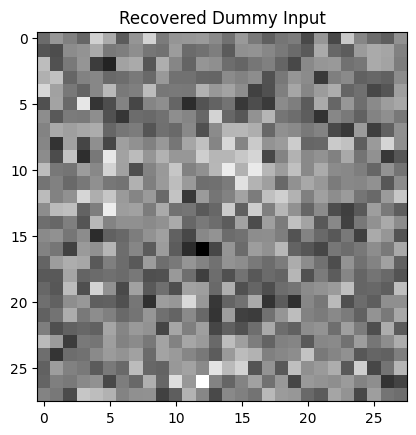

In [ ]:
import torch
from tqdm import tqdm

# Assume: 
# - model is your neural network (e.g., clients[k])
# - target_grads is a 1D tensor of the true gradients you want to match (from get_grads(model))
# - y is the target label (one-hot or integer)
# - loss_func is your loss (e.g., nn.CrossEntropyLoss())

# 1. Save the original gradients from a real batch
data, target = next(iter(train_loaders[k]))
output = clients[k](data)
loss = loss_func(output, target)
clients[k].zero_grad()
loss.backward()
target_grads = torch.cat([p.grad.view(-1) for p in clients[k].parameters()]).detach().clone()

# 2. Gradient inversion: optimize dummy input to match target_grads
dummy = torch.randn(data.shape, requires_grad=True)
optimizer = torch.optim.Adam([dummy], lr=0.1)
num_steps = 300

for step in tqdm(range(num_steps)):
    clients[k].zero_grad()
    output_dummy = clients[k](dummy)
    loss_dummy = loss_func(output_dummy, target)
    loss_dummy.backward(create_graph=True)

    dummy_grads = torch.cat([p.grad.view(-1) for p in clients[k].parameters()])

    grad_loss = torch.nn.functional.mse_loss(dummy_grads, target_grads)
    optimizer.zero_grad()
    grad_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Grad MSE: {grad_loss.item():.6f}")

# Visualize the found dummy input
import matplotlib.pyplot as plt
plt.imshow(dummy.detach()[0].view(28, 28).cpu().numpy(), cmap='gray')
plt.title("Recovered Dummy Input")
plt.show()

In [120]:
grad.shape

torch.Size([84060, 1])

In [122]:
grads[:,k].shape

torch.Size([84060])

In [ ]:
import cvxpy as cp

cp.Variable(28*28)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      100
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1275

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.0000000e+00 6.00e+00 2.18e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

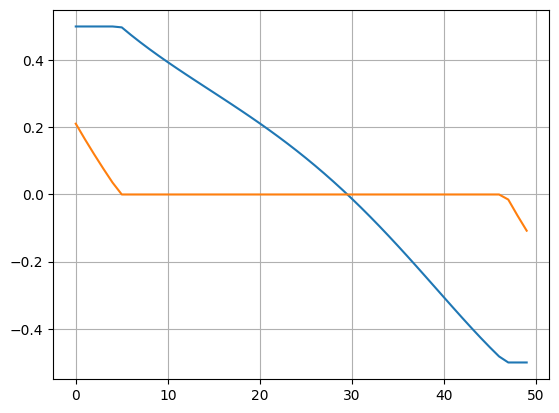

In [20]:
from casadi import *

# Control
u = MX.sym("u")

# State
x = MX.sym("x",3)
s = x[0] # position
v = x[1] # speed
m = x[2] # mass

# ODE right hand side
sdot = v
vdot = (u - 0.05 * v*v)/m
mdot = -0.1*u*u
xdot = vertcat(sdot,vdot,mdot)

# ODE right hand side function
f = Function('f', [x,u],[xdot])

# Integrate with Explicit Euler over 0.2 seconds
dt = 0.01  # Time step
xj = x
for j in range(20):
  fj = f(xj,u)
  xj += dt*fj

# Discrete time dynamics function
F = Function('F', [x,u],[xj])

# Number of control segments
nu = 50 

# Control for all segments
U = MX.sym("U",nu) 
 
# Initial conditions
X0 = MX([0,0,1])

# Integrate over all intervals
X=X0
for k in range(nu):
  X = F(X,U[k])

# Objective function and constraints
J = mtimes(U.T,U) # u'*u in Matlab
G = X[0:2]     # x(1:2) in Matlab

# NLP
nlp = {'x':U, 'f':J, 'g':G}
 
# Allocate an NLP solver
opts = {"ipopt.tol":1e-10, "expand":True}
solver = nlpsol("solver", "ipopt", nlp, opts)
arg = {}

# Bounds on u and initial condition
arg["lbx"] = -0.5
arg["ubx"] =  0.5
arg["x0"] =   0.4

# Bounds on g
arg["lbg"] = [10,0]
arg["ubg"] = [10,0]

# Solve the problem
res = solver(**arg)

# Get the solution
plt.plot(res["x"])
plt.plot(res["lam_x"])
plt.grid()
plt.show()

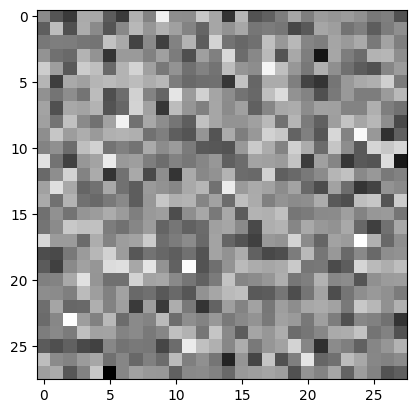

 45%|████▍     | 4479/10000 [00:23<00:29, 186.66it/s, loss=9.67e-6]


KeyboardInterrupt: 

In [14]:
k = 0

dummy = torch.randn(1,28*28, requires_grad=True)
y = torch.zeros(1,10)
y[0,3] = 1

optimizer_x = torch.optim.Adam([dummy], lr=0.01)
loss_cte = torch.nn.CrossEntropyLoss()
loss_mse = torch.nn.MSELoss()

net.clients[k].train()

with tqdm(total=10_000) as pbar:
    for i in range(10_000):
        output = clients[k](dummy)

        loss = loss_cte(output, y)
        net.clients[k].optimizer.zero_grad()
        loss.backward(create_graph=True)
        grad = net.clients[k].get_grads(grad=True)

        loss = loss_mse(grad.view(1, -1), grads[:,k].view(1, -1))
        optimizer_x.zero_grad()
        loss.backward()
        optimizer_x.step()

        if i % 100 == 0:
            clear_output(wait=True)
            plt.imshow(dummy.detach().view(28, 28).numpy(), cmap='gray')
            plt.show()

        pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)

In [299]:
y

tensor([[ 0.0167, -0.0672, -0.0306, -0.0758,  0.0583, -0.0180,  0.0119,  0.0184,
          0.0212, -0.0327]], requires_grad=True)

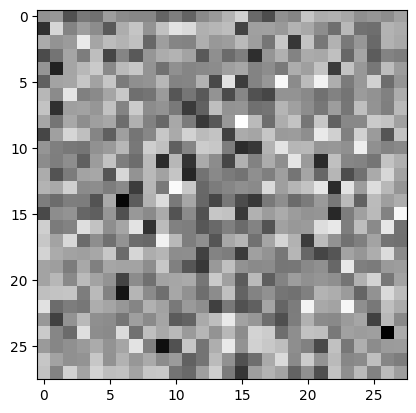

In [298]:
0
plt.imshow(dummy.detach().view(28, 28).numpy(), cmap='gray')